# splot - spatial plotting and mapping

**A package providing lightweight plotting and mapping to facilitate spatial analysis with PySAL.** 

By [Stefanie Lumnitz](https://github.com/slumnitz), [Levi John Wolf](https://github.com/ljwolf), [Dani Arribal-Bel](https://github.com/darribas), [Sergio Rey](https://github.com/sjsrey), [Taylor Oshan](https://github.com/TaylorOshan) and [Joris Van den Bossche](https://github.com/jorisvandenbossche).

The primary goal of this ['Google Summer of Code 2018' project](https://github.com/pysal/pysal/wiki/GSoC-2018---Geovisualization-Module-by-Stefanie-Lumnitz) was to design and implement the visualisation package `splot`. [`splot`](https://github.com/pysal/splot) connects spatial analysis done in the [Python Spatial Analysis Library](https://github.com/pysal), `PySAL`, to popular visualisation toolkits like [`matplotlib`](https://matplotlib.org). It provides users quick access to visualise PySAL objects, offering different views on spatial analysis workflows. The `splot` package facilitates the creation of both static plots ready for publication and interactive visualisations for quick iteration and spatial data exploration. The project has successfully achieved its primary goal and `splot` was first released in [PySAL 2.0rc2](https://github.com/pysal/pysal/releases) on [July 19 2018](https://pypi.org/project/PySAL/2.0rc2/#files).

While developing `splot`, the potential integration of different popular visualisation packages like [`bokeh`](https://bokeh.pydata.org/en/latest/) was explored. Based on the results API decisions were made, a cooperation with [`geopandas`](http://geopandas.org) was leveraged and the outline of the project changed slightly. The project now allows `splot` to potentially grow with interactive toolkits like `bokeh` in future, but focuses the current workflow on the creation of views with a `matplotlib` and `geopandas` backend. Additionally, developing new tools helped to assess PySAL's current code base and provided the opportunity to add or tweak functionality alongside `splot`'s visualizations to create an even more user-friendly library.

This notebook provides a summary of API decisions made, functionality developed and next steps planned towards a thriving `PySAL` and `splot` community in the context of the GSoC project.

## Contents

1. API Decisions
2. New `splot` functionality for:
    * esda
    * giddy
    * libpysal
    * mapping
3. Code beyond splot
4. Remaining Work & Next Steps
5. Community Outreach

### GitHub and project links

* [GSoC GitHub project](https://github.com/pysal/splot/projects/1)
* [merged pull requests](https://github.com/pysal/splot/pulls?q=is%3Apr+author%3Aslumnitz+is%3Aclosed)
* [unmerged pull requests](https://github.com/pysal/splot/pulls/slumnitz)
* [Gitter channel](https://gitter.im/pysal-gsoc18/Lobby)
* [Project Blog](https://blogs.python-gsoc.org/stefanie-lumnitz/author/stefanie-lumnitz/)

## API Decisions

**Challenges and project plan changes**

During the first phase of GSoC we created different visualisations in both a static version using `matplotlib` and an interactive version based on `bokeh`. We hereby focused on `esda.moran` objects as our first example. The original GSoC project plan proposed to design a common API for easy access to both static, and interactive versions. This would ensure that users are able to switch between `bokeh` and `matplotlib` backends without the need to change their code. However, after creating the `splot.esda.plot_moran` composite view, it was clear that we would have to cut back on the advantages each backend offers in order to provide a function signature being identical for both versions. A common API, would for example restrict full figure design accessibility for views in `matplotlib` on one hand, and limit interactive tools, like the `hover` tool, including the information displayed during the interactivity in the `bokeh` backend. Hence, we decided early on in GSoC to focus on `matplotlib` as the main backend.

Since the existing user base of `PySAL` consists of a large proportion of scientific researchers, it was important to us to offer a maximum of control over the design of all visualisations. Customization is important in creating visualisations that could also be used in scientific publications. Other reasons why we chose `matplotlib` over a `bokeh` backend include:
* `matplotlib` is already based on a much larger user and developer community. More example visualisations and good documentation already exist on diverse platforms. Furthermore, the majority of the `PySAl` userbase is more familiar `matplotlib` due to its popularity.
* Novel extensions like `IPyWidgets` or `matplotlib`'s `notebook magic` already allow a certain degree of interactivity. Additionally, quick iteration over different or slightly changed views offers another way of interactively exploring data. 
* Lastly, because of `matplotlib`'s maturity it is easier and quicker to develop new views and build on top of other packages leveraging `matlotlib` including `geopandas` or `seaborn`.

Therefore, the decision to focus on a backend using `matplotlib` and `geopandas` provided the advantage to build a user-friendly, flexible API and package structure.

**splot's structure and API**

Building on top of our experiences, `splot`'s functionality can now be accessed in two main ways: First, basic `splot` visualisations are exposed as `.plot` methods on PySAL objects. Scond, all visualisations can be found and called using a `splot.'PySAL_sub-package'` namespace, depending on the previously analysed object that needs to be visualised (e.g.`splot.giddy`). 

`.plot` methods are hereby calling `splot` under the hood. Exposing simple plots in other `PySAL` submodules ensures that the user has the quickest possible access to visualisations connected to the `PySAL` object that was created. This is especially useful for an instantaneous sanity check if the spatial analysis done in PySAL is correct, or if there are any errors present in the data used. A conventional workflow could look like this:

In [10]:
# These general imports will be used throughout the notebook
import matplotlib.pyplot as plt
from libpysal.weights.Contiguity import Queen
from libpysal import examples
import geopandas as gpd
import pandas as pd
import numpy as np

%matplotlib inline

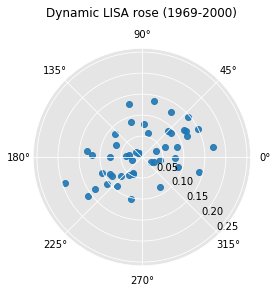

In [2]:
from giddy.directional import Rose
    
# Retrieve files and prepare data
shp_link = examples.get_path('us48.shp')
df = gpd.read_file(shp_link)
income_table = pd.read_csv(examples.get_path("usjoin.csv"))

# Calculate relative values and merge
for year in range(1969, 2010):
    income_table[str(year) + '_rel'] = (
        income_table[str(year)] / income_table[str(year)].mean())
gdf = df.merge(income_table,left_on='STATE_NAME',right_on='Name')
 
# Calculate spatial weights and data for two points in time
w = Queen.from_dataframe(gdf)
w.transform = 'r'
y1 = gdf['1969_rel'].values
y2 = gdf['2000_rel'].values

# Calculate rose Object
Y = np.array([y1, y2]).T
rose = Rose(Y, w, k=5)

# Plot
fig, ax = rose.plot()
ax.set_title('Dynamic LISA rose (1969-2000)\n')
plt.show()

Furthermore, all visualisations connected to analysis done in a specific PySAL sub-package can be called using the `splot.'PySAL_sub-package'` namespace. This is especially helpful in complex spatial analysis workflows when multiple PySAL objects, submodules and visualizations need to be integrated. Or if the user needs full access and control over the different visualisations. A simple example how to access visualisations through this option is given here:

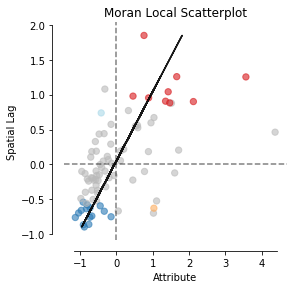

In [3]:
from esda.moran import Moran_Local
from splot.esda import moran_scatterplot

# Data preparation and spatial analysis
link_to_data = examples.get_path('Guerry.shp')
gdf = gpd.read_file(link_to_data)
y = gdf['Donatns'].values
w = Queen.from_dataframe(gdf)
w.transform = 'r'
moran_loc = Moran_Local(y, w)

# Plot
fig = plt.figure(figsize=(4,4))
ax = fig.add_subplot(111)
moran_scatterplot(moran_loc, p=0.05, ax=ax)
plt.show()

Lastly, `splot.utils` and `splot.mapping` provide additional utility and mapping functionality that can greatly enhance geospatial analysis and information, but are not directly tied to one specific `PySAL` sub-package. The `.utils` and `.mapping` namespaces therefore universally enhance workflows specific to all other `PySAL` sub-packages and are accessed separately. 

**References and additional information**
* [API Discussion](https://github.com/pysal/splot/issues/9)
* [Future Exploration of potential interfaces for alternative packages](https://github.com/pysal/splot/issues/22)
* [Idea Collection: Cooperation between `geopandas` and `splot`](https://github.com/pysal/splot/issues/21)
* [GSoC Blogpost](https://blogs.python-gsoc.org/stefanie-lumnitz/2018/06/11/designing-the-splot-api/)

## New splot functionality

We followed three main guidelines developing `splot`'s functionality:
1. To provide users with simple visualisations and multi-views that allow for a more in depth analysis, where possible. Based on our own experience in spatial analysis we are aiming to shine light on different angles of the analysed problem utilizing simple multi-plots.
2. To choose sensible design settings and analysis defaults to enhance the ease and speed of use.
3. To allow customization of all visualisations using keyword dictionaries. To allow scientific users to leverage `splot` for scientific presentations.

Additionally we aimed to implement all functionality with a consistent API, especially within the `splot.'sub-package'` namespaces and as much as possible also between different `splot` submodules. All visualisation functionality takes a `matplotlib` Axes instance as an input argument which defaults to `ax=None`. `ax=` is needed since users may already have a Figure instance with one or more `matplotlib` Axes instances defined (often in a custom layout), and want to use an `splot` function to draw a plot inside one of those already defined Axes. Furthermore, all `splot` functionality commonly returns a `matplotlib` Figure instance and Axes instance. A `fig` instance may be needed for high level operations like display, close or save a figure (e.g. `fig.savefig('moran_scatterplot.png')`). Respectively, an `ax` instance may be needed to modify the plot itself, e.g. customize a title, or plot a scatter plot on top.

Building and designing `splot` as a package furthermore required that all user exposed functionality has documentation and is unit tested. We also added a notebook for each of the `splot.'sub-package'` namespaces, showcasing functionality and documenting `splot`'s use in detail. Lastly, packaging required to keep `requirements.txt` and `.travis.yml` up to date to all changes and decide on soft and hard dependencies. All required dependencies and an introduction on how to use and develop `splot` is given in `splot`'s new `README.md`.

The following sections will provide an overview on functionality that was created and advantages and reasons of the chosen API design. We will highlight a couple of views we regard as most popular in future. The full idea collection and discussion on what functionality to support in `splot` can be found [here](https://github.com/pysal/splot/issues/10).

**General References and Pull Requests**

* [splot Documentation](http://pysal.org/docs.html)
* [merged PR: start documentation using Sphinx](https://github.com/pysal/splot/pull/12)
* [merged PR: debug `setup.py`](https://github.com/pysal/splot/pull/16)
* [merged PR: debug documentation](https://github.com/pysal/splot/pull/25)
* [merged PR: add README.py](https://github.com/pysal/splot/pull/29)

### splot.esda

**Enhancing Exploratory Spatial Data Analysis (esda) with `splot` views**

[`esda`]() is one of the most widely used sub-packages of PySAL and provides tools for exploratory spatial data analysis that consider the role of space in a distribution of attribute values. Due to it's importance in the library, it was the first of the `PySAL` sub-packages we designed and developed functionality for.

`splot` primarily supports Moran analytics done with `esda.moran` and offers a range of single visualisations and combined views for more complex analysis. Currently we have worked towards `splot` supporting the following objects:
* **`esda.moran.Moran`** with `moran_scatterplot()`, `plot_moran_simulation` and `plot_moran`
* **`esda.moran.Moran_BV`** with `moran_scatterplot()`, `plot_moran_bv_simulation` and `plot_moran_bv`
* **`esda.moran.Moran_Local`** with `moran_scatterplot()`, `lisa_cluster()` and `plot_local_autocorrelation()`
* **`esda.moran.Moran_Local_BV`** with `moran_scatterplot()`, `lisa_cluster()` and `plot_local_autocorrelation()`
* **`esda.moran.Moran_matrix`** with `moran_facet()`

**The same view for multiple objects: moran_scatterplot()**

A simple `moran_scatterplot()` call will create a classic Moran Scatterplot for any of the four Moran analytics objects (Moran, Moran_BV, Moran_Local, Moran_Local_BV):

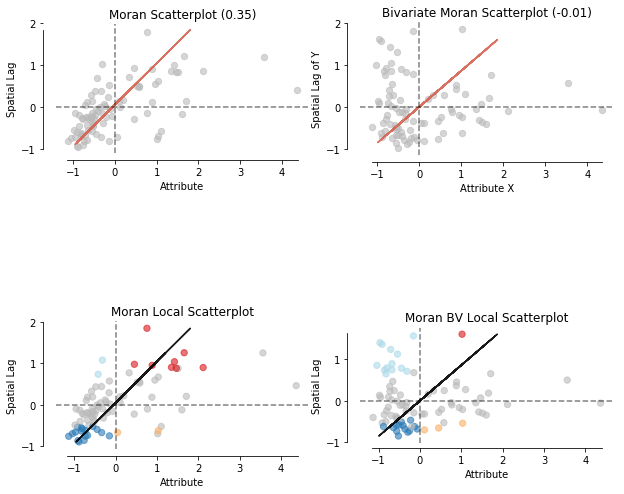

In [4]:
from esda.moran import Moran, Moran_BV, Moran_Local, Moran_Local_BV
from splot.esda import moran_scatterplot

# We use the same data as in the previous examples
x = gdf['Suicids'].values

# Generate Moran objects
moran = Moran(y,w)
moran_bv = Moran_BV(y, x, w)
moran_loc = Moran_Local(y, w)
moran_loc_bv = Moran_Local_BV(y, x, w)


# Plot
fig, axs = plt.subplots(2, 2, figsize=(10,10),
                        subplot_kw={'aspect': 'equal'})

moran_scatterplot(moran, ax=axs[0,0])
moran_scatterplot(moran_loc, p=0.05, ax=axs[1,0])
moran_scatterplot(moran_bv, ax=axs[0,1])
moran_scatterplot(moran_loc_bv, p=0.05, ax=axs[1,1])
plt.show()

We hereby integrated four different hidden visualisation functions into one. This helps keep the `splot` API small and again enhances ease of use. In addition, users have the choice to display their original or standardised data, to color points by significance in case `Moran_Local` or `Moran_local_BV` are input objects and of course customize the plot using `scatter_kwds` and `fitline_kwds`.



**Combining classic views with new analysis: plot_moran_simulation()**

`plot_moran_simulation()` and `plot_moran_bv_simulation()` offer users a view to compare the calculated Moran value to a Reference distribution and check wether the calculated Moran or bivariate Moran statistics are significant. The `splot` functionality hereby simulates a normal distribution using a `seaborn.kdeplot` under the hood:

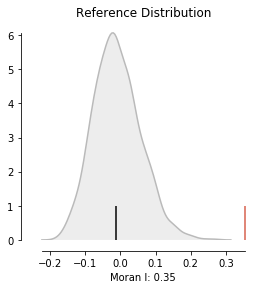

In [5]:
from esda.moran import Moran
from splot.esda import plot_moran_simulation

# used with the same data introduced in the first chapter
moran = Moran(y,w)

# plot
fig = plt.figure(figsize=(4,4))
ax = fig.add_subplot(111)
plot_moran_simulation(moran, ax=ax)
plt.show()

**Emphasizing simple multi-views: plot_moran() & plot_local_autocorrelation()**

Our personal experience conducting research taught us it is often easier or even necessary to asses and intepret spatial statistical results comparing different views and shining light from different angles. Therefore we started to create simple multi-views right from the beginning on in GSoC.

`plot_moran` for example provides a combined view of `plot_moran_scatterplot()` or `plot_moran_bv_simulation()` and `moran_scatterplot()`. The simple name `plot_moran()` was chosen to direct the user to call this function first since a combined view enhances the understanding of the calculated Moran Statistics significantly. The idea is to only utilize individual views of `plot_moran_scatterplot()` or `moran_scatterplot()` for specific purposes, e.g. to include a simple visualisation in another customized visualisation using the `ax=` argument.

Another simple multi-view plot is `plot_local_autocorrelation()`. This `splot` view combines a Moran Scatterplot, LISA cluster map and Choropleth map. This allows the user to not only distinguish between hot and cold spots, indicated through the Moran scatterplot, but also directly locate these areas of interest on a map:

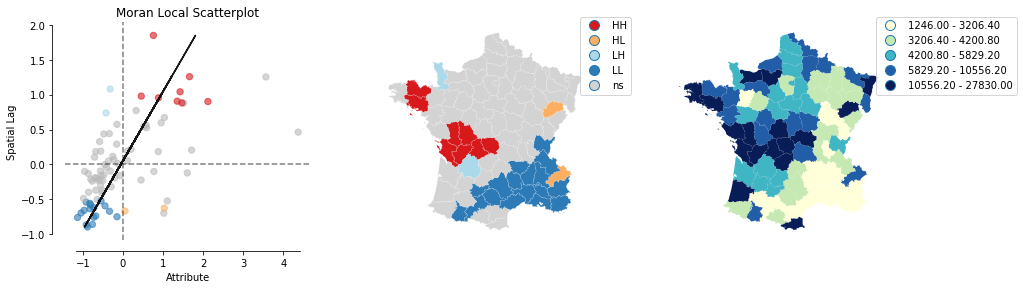

In [6]:
from esda.moran import Moran_Local
from splot.esda import plot_local_autocorrelation

plot_local_autocorrelation(moran_loc, gdf, 'Donatns')
plt.show()

This view provides again, the opportunity to spot errors in the database, the underlying statistical calculation and already provides a way to interpret results in a spatial context. Additionally it offers masking options and opportunities to assess how values in different quadrants of the Moran scatterplot are distributed over space:

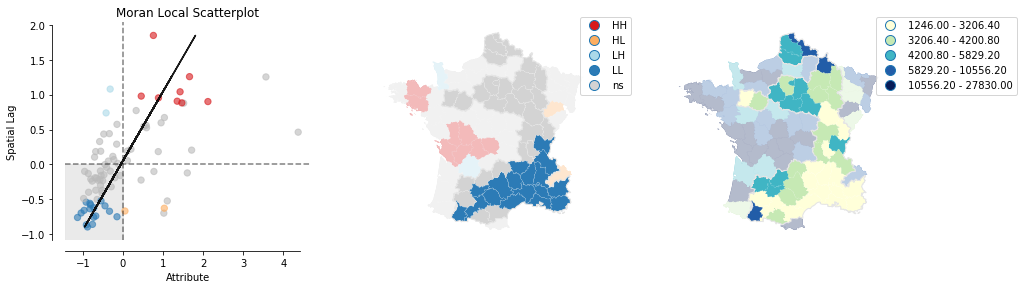

In [7]:
plot_local_autocorrelation(moran_loc, gdf, 'Donatns', quadrant=3)
plt.show()

If you are interested in Local Spatial Autocorrelation or other spatial analysis workflows and their underlying theories, `splot` provides [comprehensive notebooks](https://github.com/slumnitz/splot/tree/gsoc/notebooks) for teaching or as extended documentation to all visualizations.

**References and Pull Requests**

* [blog_post: Visualising Spatial Autocorrelation](https://blogs.python-gsoc.org/stefanie-lumnitz/2018/05/26/gsoc-milestone-1-visualising-spatial-autocorrelation/)
* [blog post: `moran_facet`](https://blogs.python-gsoc.org/stefanie-lumnitz/2018/07/23/from-scipy2018-import-pysal2-0rc2/)
* [merged PR: add significance option to `moran_scatterplot`](https://github.com/pysal/splot/pull/7)
* [merged PR: Local Autocorrelation](https://github.com/pysal/splot/pull/8)
* [merged PR: creating `splot.esda`](https://github.com/pysal/splot/pull/13)
* [merged PR: add `moran_scatterplot`, `plot_moran_simulation` and `plot_moran`](https://github.com/pysal/splot/pull/17)
* [merged PR: create `Moran_BV` functionality](https://github.com/pysal/splot/pull/18)
* [merged PR: create `Moran_Local_BV` functionality](https://github.com/pysal/splot/pull/20)
* [submitted PR: add `moran_facet`](https://github.com/pysal/splot/pull/27)

### splot.giddy

**Visualising space–time analytics that consider the role of space in the evolution of distributions over time**

In addition to `esda`, `giddy` offers the opportunity for spatial statistical analysis examining processes over time. Already in `esda` introduced Local indicators of spatial association (LISA) can be analysed in a dynamic context, offering insights into space-time hot-spots (and cold-spots). Being able to build on top of `splot.esda` functionality, designing and creating `splot.giddy` was the natural next choice.

`splot` functionality currently supports:
* **`giddy.directional.Rose`** with
    * `dynamic_lisa_heatmap()`
    * `dynamic_lisa_rose()`
    * `dynamic_lisa_vectors()`
    * `dynamic_lisa_composite()` and
    * `dynamic_lisa_composite_explore()`

**Interactive matplotlib leveraging `IPyWidgets`: dynamic_lisa_composite_explore()**

Developing `splot.giddy`'s functionality, we introduced a new idea to the package to create user-friendly interactive views leveraging `IPyWidgets`. Since `giddy` provides tools to examine spatial phenomena over time, we decided to implement `dynamic_lisa_composite_explore()`. This function allows `giddy` and `splot` users to dynamically explore changes in the spatial distribution of hot and cold-spots over time. An `IPyWidgets` drop down menu based on `ipywidgets.interact` provides an easy option to change the input variable (e.g. the year of interest) and automatically updates the plot. This functionality is currently dependent on the use of a Jupyter notebook, but gives a blue print on how future interactive packages could be integrated into `splot`, including `_explore` in the function name. 

**References and Pull Requests**

* [Blog post including giddy visualizations](https://blogs.python-gsoc.org/stefanie-lumnitz/2018/06/11/designing-the-splot-api/)
* [merged PR: giddy dynamic LISA functionality](https://github.com/pysal/splot/pull/11)


### splot.libpysal

**Visualisations for all core components of Python Spatial Analysis Library in `libpysal`**

As demonstrated by previous examples `libpysal` and especially the `weights` functionality is frequently used for many different spatial analysis workflows done with all `PySAL` submodules. Due to new functionality `libpysal.weights.util.nonplanar_neighbors` added by Levi during the refactoring of PySAL, we decided to support `weight` objects next.

(`nonplanar_neighbors` offers a tool to calculate spatial weights in case a digitization error lead to neighbouring polygons incorrectly not sharing edges and nodes.)

`libpysal` functionality supported by splot includes:
* `libpysal.weights` with `plot_spatial_weights()`

**Changing views with additional analysis: plot_spatial_weights()**

This functionality simply takes a `weights` object and a `geopandas` GeoDataFrame as an input argument and maps the spatial weights network on top of the underlying polygons. In case `nonplanar_neighbors` were calculated beforehand or after, the functionality automatically detects the new attribute of the `weights` object `weights.non_planar_joins` and plots all new joins in a different default color. Of course like in other cases, dictionaries can be used to implement personal design choices as needed:

/Users/steffie/code/libpysal/libpysal/weights/weights.py:189: UserWarning: There are 30 disconnected observations
  warnings.warn("There are %d disconnected observations" % ni)
/Users/steffie/code/libpysal/libpysal/weights/weights.py:190: UserWarning: Island ids: 0, 1, 5, 24, 28, 81, 95, 102, 108, 110, 120, 123, 140, 170, 176, 224, 240, 248, 254, 255, 256, 257, 262, 277, 292, 295, 304, 322, 358, 375
  warnings.warn("Island ids: %s" % ', '.join(str(island) for island in self.islands))


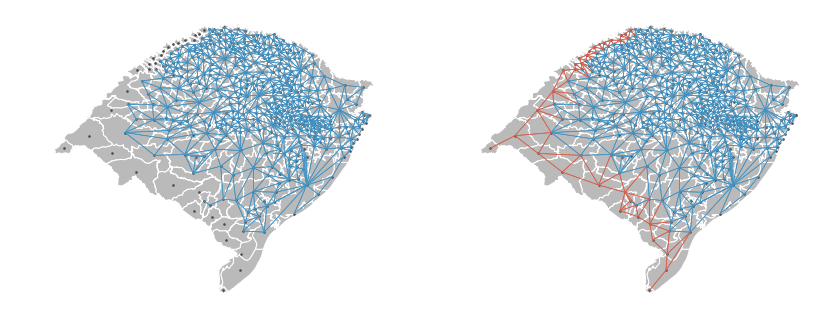

In [8]:
from splot.libpysal import plot_spatial_weights
from libpysal.weights.util import nonplanar_neighbors

# Data preparation and statistical analysis
gdf = gpd.read_file(examples.get_path('43MUE250GC_SIR.shp'))
weights = Queen.from_dataframe(gdf)
wnp = nonplanar_neighbors(weights, gdf)

# Plot
fig, axs = plt.subplots(1,2, figsize=(14,7))
plot_spatial_weights(weights, gdf, ax=axs[0])
plot_spatial_weights(wnp, gdf, ax=axs[1])
plt.show()

**related links and PR's**
* [Blog Post: Introducing `splot.libpysal`](https://blogs.python-gsoc.org/stefanie-lumnitz/2018/07/09/milestone-2-sprinting-towards-ansplot-release/)
* [merged PR: creating `plot_spatial_weights()`](https://github.com/pysal/splot/pull/14)

### splot.mapping

**Universal Choropleth visualizations and mapping utilities**

In addition to object and `PySAL` sub-package specific analytical visualizations `splot` offers a range of `.mapping` and visualization utility functionality. This functionality can be extended in future to be `splot`'s designated core functionality, offering classic visual diagnostic tools for spatial analysis. Map and cartographic visualisations, for example, provide great potential to examine spatial processes, dynamics and relationships with only minor additional underlying data processing. Furthermore, this mapping fucntionality is not only advantageous to use on its own but a great addition to several `PySAL` sub-packages like `mapclassify`.

`splot` functionality currently offers:
* **Value-by-Alpha map functionality** including:
    * `value_by_alpha_cmap()`
    * `vba_choropleth()`
    * `vba_legend()`
* **`mapclassify` value binning** with `mapclassify_bin()`
* **Colormap utilities** including:
    * `shift_colormap()`
    * `truncate_colormap()`

**Visual analytics using: vba_choropleth()**

In a nutshell, a Value-by-Alpha Choropleth is a bivariate choropleth that uses the values of the second input variable `y` as a transparency mask, determining how much of the choropleth displaying the values of a first variable `x` is shown. In comparison to a cartogram, Value-By-Alpha choropleths will not distort shapes and sizes but modify the alpha channel (transparency) of polygons according to the second input variable `y`. A Value-by-Alpha Choropleth is therefore another powerful tool to examine relationships of two variable in space:

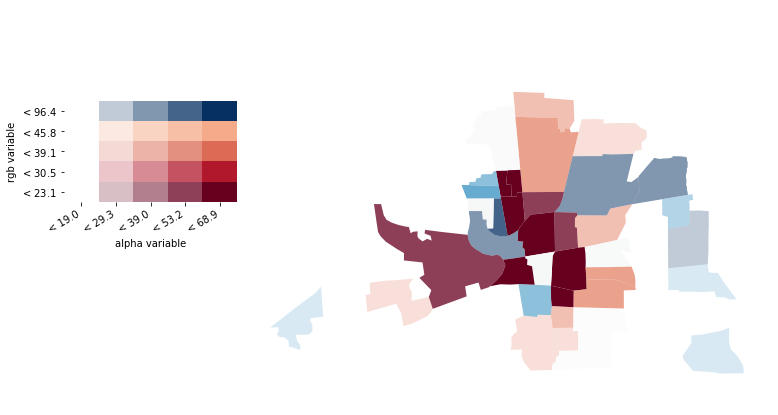

In [9]:
from splot.mapping import vba_choropleth

link_to_data = examples.get_path('columbus.shp')
gdf = gpd.read_file(link_to_data)

x = gdf['HOVAL'].values # housing value (in $1,000)
y = gdf['CRIME'].values # residential burglaries and vehicle thefts per 1000 households

fig = plt.figure(figsize=(12,7))
ax = fig.add_subplot(111)
vba_choropleth(x, y, gdf,
               alpha_mapclassify=dict(classifier='quantiles', k=5),
               rgb_mapclassify=dict(classifier='quantiles', k=5),
               legend=True, cmap='RdBu', ax=ax)
plt.show()

**related links and PR's**

* [Blog Post: Value-by-Alpha maps with `splot`](https://blogs.python-gsoc.org/stefanie-lumnitz/2018/08/04/value-by-alpha-maps-with-splot/)
* [submitted PR: Value-by-Alpha Choropleth](https://github.com/pysal/splot/pull/28)

## Code beyond splot

Developing new visualisation tools for `PySAL` helped to assess important sub-packages' current code base. Working on `splot` functionality provided the opportunity to add or tweak functionality alongside splot's visualizations to create an even more user-friendly `PySAL` library. Furthermore, already described `.plot` methods were added to the respective sub-packages. Code that was written beyond `splot` includes:

**merged PR's**

* [Add 'Guerry' example data to libpysal](https://github.com/pysal/libpysal/pull/45)
* [debug documentation in libpysal](https://github.com/pysal/libpysal/pull/54)
* [implement `rose.plot()` methods](https://github.com/pysal/giddy/pull/43)
* [test and document `rose.plot()` methods](https://github.com/pysal/giddy/pull/47)
* [divide `.z` attribute by standard deviation in esda](https://github.com/pysal/esda/pull/21)
* [add a `.varnames` attribute to a Moran_BV object in esda](https://github.com/pysal/esda/pull/23)

**open PR's**

* [implement `.plot` methods for `esda.moran`](https://github.com/pysal/esda/pull/19)
* [replace `libpysal.api` in giddy](https://github.com/pysal/giddy/pull/61)

**closed issues**
* [offer standardised and non z standardised values in esda](https://github.com/pysal/esda/issues/20)
* [add `.varnames` attribute to `Moran_BV_matrix`](https://github.com/pysal/esda/issues/22)


## Remaining work & next steps

Throughout the Summer of Code, the main challenge was coordinating the creation of `splot` and the [refactoring](http://pysal.org/about.html?highlight=migrating) of `PySAL` to `PySAL 2.0`. Due to changes in the API of `libpysal` and `mapclassify` and the overall change of sub-package structure in PySAl, it remains a challenge to continuously adapt `splots` functionality to these new or planned modifications. PR that are currently blocked due to changes in `libpysal` and `mapclassify` API's include:
* [submitted PR: Value-by-Alpha Choropleth](https://github.com/pysal/splot/pull/28)
* [submitted PR: add `moran_facet`](https://github.com/pysal/splot/pull/27)

Once these PR's are merged all of `splot`'s introduced functionality will be accessible and usable. The most important next step will be to release `splot` as a separate package, additionally to the library release `PySAL 2.0rc2`. This package release will likely take place at the end of August 2018. 

In future we are planning on extending `splot`s functionality so that analysis with all `PySAL` subpackages will be supported by `splot` visualisations. Once users start leveraging `splot`'s views and are able to provide feedback, we are also striving to improve the current functionality if needed. To encourage newly joining developers and a thriving `PySAL` and `splot` community we are currently discussing an overall Code of Conduct. To allow for easy contribution every `.py` file in `splot` provides our ideas and plans for improvements of the views and code. Lastly, an attractive `README.md` and good documentation is important to us to provide new users and developers the best possible start within the `splot` and `PySAL` community.

## Community Outreach

During the Summer of Code and within the scope of developing `splot`, the whole development team had the chance to collaborate and communicate with other package developers in the Scientific Python Open Source Software Community. 

We would like to give many thanks to [Rebecca Bilbro](https://github.com/rebeccabilbro) and [Benjamin Bengfort](https://github.com/bbengfort) to share their experiences and knowledge with us developing the [`yellowbrick`](http://www.scikit-yb.org/en/latest/) package. We made good use of their advice that it is good to just get started with one API and that it's always possible to create another one, for example leveraging other packages as backend later on. Also thank you to [Joris van den Bossche](https://github.com/jorisvandenbossche) and the geopandas development team. Without their decision to time a geopandas 0.4.0 release with an `splot` release, the first `splot` release would not have been possible.

Furthermore, [Sergio Rey](https://github.com/sjsrey) [Dani Arribas-Bel](https://github.com/darribas), [Levi John Wolf](https://github.com/ljwolf) and [I](https://github.com/slumnitz) were able to meet for a common `PySAL` and `splot` sprint at [SciPy 2018](https://scipy2018.scipy.org/ehome/index.php?eventid=299527&). This provided the basis for the first release and I was also able to present `splot` in a [lightning talk](https://youtu.be/kriQOJMycIQ?t=2381) to the broader Scientific Python community. Lastly, many thanks to my mentors and the whole [PySAL development team](http://pysal.org/team.html) for loads of fun coding and google hangouts sessions. I had a great time this summer and am looking forward to being part of this welcoming Python community way beyond this Google Summer of Code!